In [24]:
import pandas as pd
import numpy as np
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)
from tqdm import tqdm
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
tqdm.pandas()

# Import data and modules for lemmatization

In [25]:
data = pd.read_excel('manifest_balanced.xlsx')

In [26]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)

# Lemmatize text

In [27]:
def get_lemmas(text, morph_vocab):
    try:
        doc = Doc(text)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        for token in doc.tokens:
            token.lemmatize(morph_vocab)
        lemmas = []
        for token in doc.tokens:
            if token.pos != 'PUNCT' and token.text != '=':
                lemmas.append(token.lemma)
        return lemmas
    except:
        return None

In [29]:
data['lemmas'] = data.progress_apply(lambda x: get_lemmas(x['text'], morph_vocab), axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 55657/55657 [01:28<00:00, 627.78it/s]


# Count intersections between corpora

In [30]:
corpus_lemmas = {}
for corpus in data['corpus'].unique():
    data_f = data[data['corpus'] == corpus]
    resultList = [element for nestedlist in data_f['lemmas'] if nestedlist != None for element in nestedlist]
    d = list(resultList)
    corpus_lemmas[corpus] = d

In [31]:
shared_lemmas = []
for corpus1, lemmas1 in corpus_lemmas.items():
    for corpus2, lemmas2 in corpus_lemmas.items():
        res = list(set(lemmas1) & set(lemmas2))
        c = len(res) / (len(set(lemmas1 + lemmas2)))
        shared_lemmas.append([corpus1, corpus2, c])

Show amount of intersections between corpora

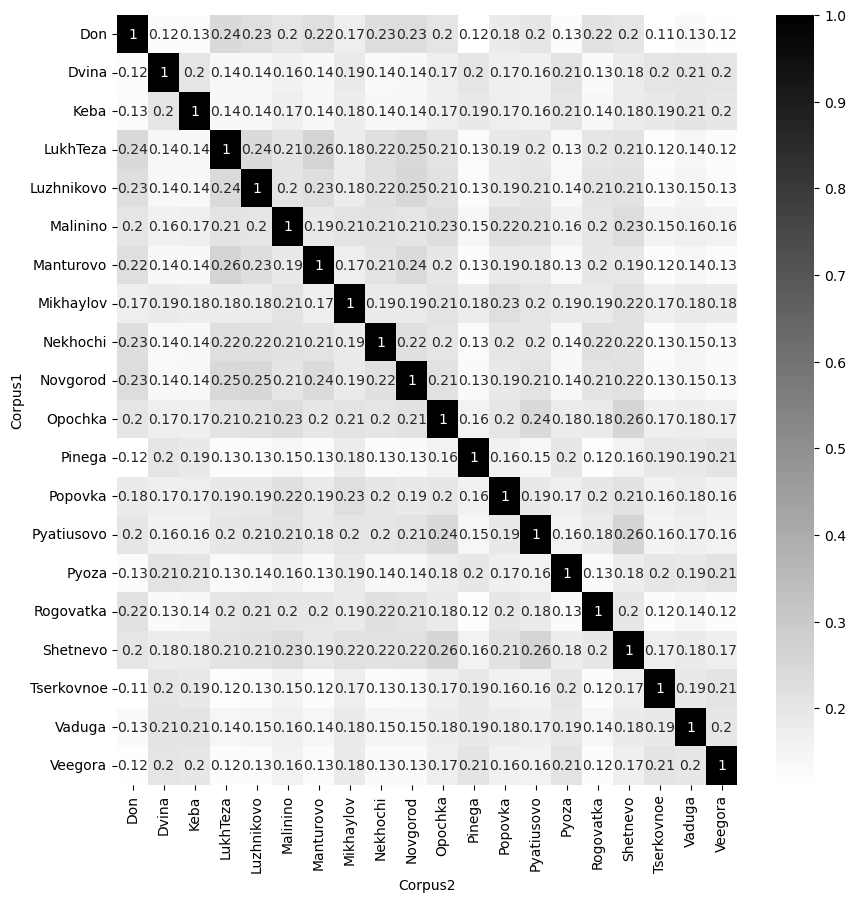

In [33]:
plt.rcParams["figure.figsize"] = (10,10)
df_shared_lemmas = pd.DataFrame(shared_lemmas, columns=['Corpus1', 'Corpus2', 'Share'])
sns.heatmap(df_shared_lemmas.pivot(index="Corpus1", columns="Corpus2", values="Share"), annot = True, fmt='.2g', cmap='binary')
plt.show()

# Statistics for corpora intersections

In [34]:
keep = np.triu(np.ones(df_shared_lemmas.pivot(index="Corpus1", columns="Corpus2", values="Share").shape), k=1).astype('bool').reshape(df_shared_lemmas.pivot(index="Corpus1", columns="Corpus2", values="Share").size)
dict_coeff = df_shared_lemmas.pivot(index="Corpus1", columns="Corpus2", values="Share").stack()[keep].to_dict()
np.std(list(dict_coeff.values()))

0.03517386411904494

In [35]:
np.mean(list(dict_coeff.values()))

0.17938731314837236

In [36]:
def rename_group(name):
    d = {'Arkhangelskie': 'Архангельские',
         'Desninskie': 'Верхне-Деснинские',
         'Donskie': 'Донские',
         'Kostromskie': 'Костромские',
         'Mezhzonalnie': 'Межзональная группа Б',
         'Novgorodskie': 'Новгородские',
         'Povolzkie': 'Владимирско-Поволжские',
         'Pskovskie': 'Псковские',
         'Ryazanskie': 'Рязанские',
         'Seligerskie': 'Селигеро-Торжковские'}
    return d[name]

data['variant_rus'] = data['Variant'].apply(rename_group)

# Count intersections between groups of dialect

In [37]:
group_lemmas = {}
for group in data['variant_rus'].unique():
    data_f = data[data['variant_rus'] == group]
    resultList = [element for nestedlist in data_f['lemmas'] if nestedlist != None for element in nestedlist]
    d = list(resultList)
    group_lemmas[group] = d

In [38]:
shared_lemmas_group = []
for group1, lemmas1 in group_lemmas.items():
    for group2, lemmas2 in group_lemmas.items():
        res = list(set(lemmas1) & set(lemmas2))
        c = len(res) / (len(set(lemmas1 + lemmas2)))
        shared_lemmas_group.append([group1, group2, c])

Show amount of intersections between corpora

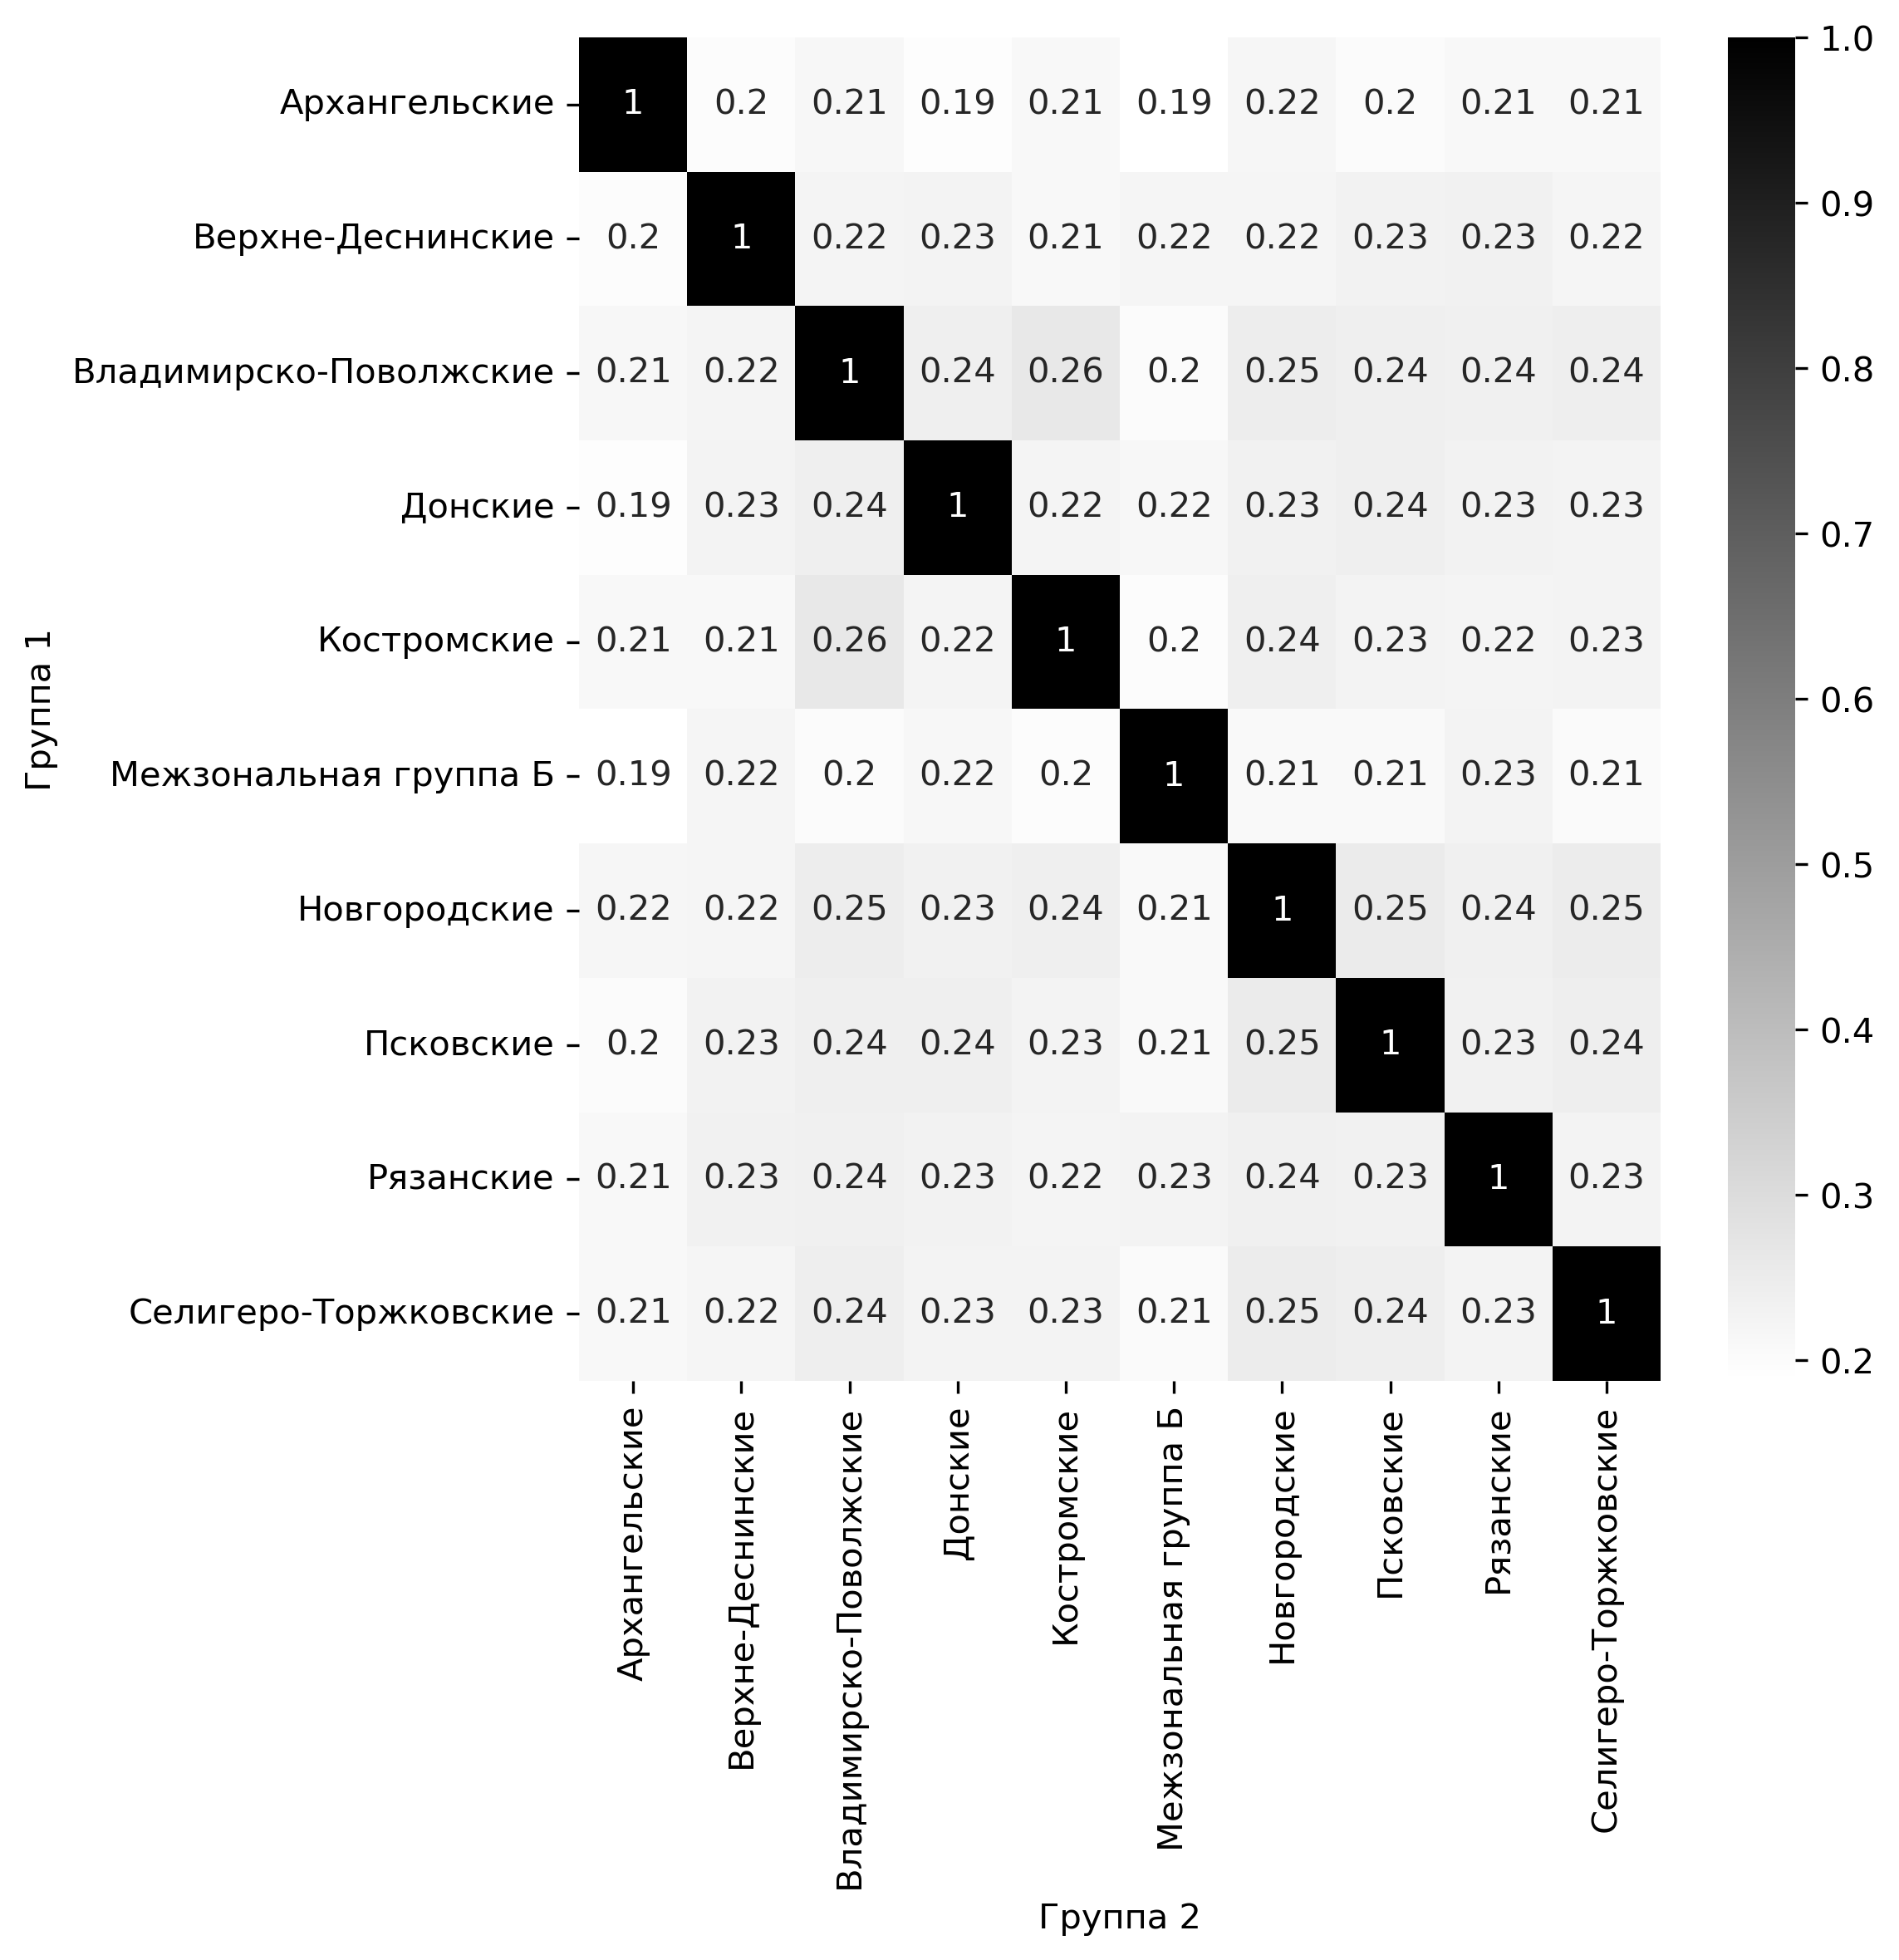

In [39]:
plt.figure(figsize=(7, 7), dpi=300)
df_shared_lemmas_group = pd.DataFrame(shared_lemmas_group, columns=['Группа 1', 'Группа 2', 'Share'])
ax = sns.heatmap(df_shared_lemmas_group.pivot(index="Группа 1", columns="Группа 2", values="Share"), 
            annot = True, fmt='.2g', cmap='binary')
ax.set_xticklabels(df_shared_lemmas_group.pivot(index="Группа 1", columns="Группа 2", values="Share").index, rotation=90)
ax.set_yticklabels(df_shared_lemmas_group.pivot(index="Группа 1", columns="Группа 2", values="Share").index, rotation=0)
plt.savefig('heatmap.jpg', bbox_inches='tight')

# Statistics for group intersections

In [40]:
keep = np.triu(np.ones(df_shared_lemmas.pivot(index="Corpus1", columns="Corpus2", values="Share").shape), k=1).astype('bool').reshape(df_shared_lemmas.pivot(index="Corpus1", columns="Corpus2", values="Share").size)
dict_coeff = df_shared_lemmas.pivot(index="Corpus1", columns="Corpus2", values="Share").stack()[keep].to_dict()
np.std(list(dict_coeff.values()))

0.03517386411904494

In [42]:
keep = np.triu(np.ones(df_shared_lemmas_group.pivot(index="Группа 1", columns="Группа 2", values="Share").shape), k=1).astype('bool').reshape(df_shared_lemmas_group.pivot(index="Группа 1", columns="Группа 2", values="Share").size)
dict_coeff = df_shared_lemmas_group.pivot(index="Группа 1", columns="Группа 2", values="Share").stack()[keep].to_dict()
np.std(list(dict_coeff.values()))

0.01624388092055565

In [43]:
np.mean(list(dict_coeff.values()))

0.22390892284512354